# Importação de bibliotecas

In [63]:
import pandas as pd
from scipy.stats import normaltest
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.stats.weightstats import CompareMeans
from scipy.stats import wilcoxon, ranksums
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Carregamento dos dados

In [51]:
dados = pd.read_csv('/Users/mikeiasoliveira/Downloads/02 - Outros/microdados_enem_2020/DADOS/MICRODADOS_ENEM_2020.csv', encoding='latin-1', sep=';')

In [52]:
dados = dados[['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
       'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC',
       'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
       'TX_RESPOSTAS_MT', 'TP_LINGUA', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
       'TX_GABARITO_LC', 'TX_GABARITO_MT', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO']]

# Limpeza dos dados

In [57]:
dados.NU_INSCRICAO = dados.NU_INSCRICAO.fillna(0)

In [76]:
dados_sem_redacao_0 = dados.drop(index = dados.loc[dados.NU_NOTA_REDACAO == 0].index)

# Testes estatísticos

## Teste de normalidade

Definifinição de função para teste de normalidade:

In [66]:
def teste_normalidade(dados, coluna):
    
    sm.qqplot(dados[coluna], line ='45', fit = True)
    
    stats_normTestRedacao, p_valor = normaltest(dados.NU_NOTA_REDACAO)
    print(f'O P-value é igual a: {round(p_valor, 5)}')
    
    if p_valor > 0.5:
        print('Hipótese nula aceita')
    else: 
        print('Hipótese nula rejeitada')
    
    plt.show()

O P-value é igual a: 0.0
Hipótese nula rejeitada


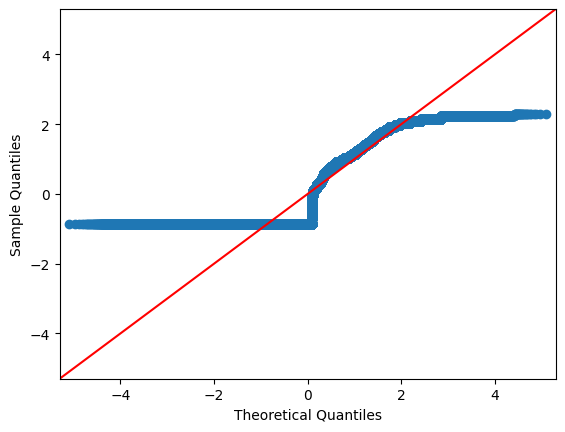

In [67]:
teste_normalidade(dados, 'NU_NOTA_REDACAO')

$ H_0: $ A distribuição provém de uma distribuição normal <br>
$ H_1: $ A distribuição não provém de uma distribuição normal <br>
$ p-value > \alpha $ <br><br>

<font color='red'>A amostra não provém de uma distribuição normal</font>


----

## Análise por parâmetros

Temos que:

Código|Raça|
------|----|
0|Não declarado
1|Branca
2|Preta
3|Parda
4|Amarela
5|Indígena 

### Renomeando variáveis

In [68]:
dados.TP_COR_RACA.replace({0:'Não declarado', 1:'Branca', 2:'Preta', 3:'Parda', 4:'Amarela', 5:'Indígena'}, inplace = True)

---

### Automatizando teste estatístico

In [87]:
def teste_hipotese_redacao(dados, hipotese, coluna_teste):
    sexo_1 = list(dados[coluna_teste].unique())
    sexo_2 = list(dados[coluna_teste].unique())

    sexo_pd_1 = []
    sexo_pd_2 = []
    p_values = []
    hipoteses = []

    validacao = []

    for i in sexo_1:
        for j in sexo_2:
            if i != j:


                amostras_i = dados.query(f"{coluna_teste} == '{i}'")['NU_NOTA_REDACAO']
                amostras_j = dados.query(f"{coluna_teste} == '{j}'")['NU_NOTA_REDACAO']
                        
                teste_i = DescrStatsW(amostras_i)
                teste_j = DescrStatsW(amostras_j)
                        

                sexo_pd_1.append(i)
                sexo_pd_2.append(j)

                teste = teste_i.get_compare(teste_j)
                _, p_value, _ = teste.ttest_ind(alternative = hipotese)
                p_values.append(p_value)

                if p_value > 0.05:
                    hipoteses.append('Aceito')
                else:
                    hipoteses.append('Rejeitado')
        sexo_2.remove(i)
    df_hipotese = pd.DataFrame({f'{coluna_teste}_1':sexo_pd_2, f'{coluna_teste}_2': sexo_pd_1,'p_value':p_values, 'hipotese':hipoteses})
    return df_hipotese


#### Sexo

---

In [70]:
dados.TP_SEXO.value_counts(normalize=True)

F    0.599817
M    0.400183
Name: TP_SEXO, dtype: float64

In [77]:
dados_sem_redacao_0.groupby('TP_SEXO').NU_NOTA_REDACAO.mean()

TP_SEXO
F    602.812649
M    571.220865
Name: NU_NOTA_REDACAO, dtype: float64

In [78]:
dados.groupby('TP_SEXO').NU_NOTA_REDACAO.mean()

TP_SEXO
F    282.149905
M    259.488779
Name: NU_NOTA_REDACAO, dtype: float64

$H_0$: A nota da média redação de Mulheres é igual a de Homens<br>
$H_1$: A nota da média redação de Mulheres é diferente a de Homens

In [79]:
teste_hipotese_redacao(dados_sem_redacao_0, 'two-sided', 'TP_SEXO')

,TP_SEXO_1,TP_SEXO_2,p_value,hipotese
0,M,F,0.0,Rejeitado


$H_0$: A nota da média redação de Mulheres é igual a de Homens <br> <font color='red'>Rejeitado</font> <br><br>
$H_1$: A nota da média redação de Mulheres é diferente a de Homens <br> <font color='green'>Aceito</font> <br><br>

---

$H_0$: A nota da média redação de Mulheres é menor do que de Homens<br>
$H_1$: A nota da média redação de Mulheres é maior do que de Homens

In [80]:
teste_hipotese_redacao(dados_sem_redacao_0, 'smaller', 'TP_SEXO')

,TP_SEXO_1,TP_SEXO_2,p_value,hipotese
0,M,F,0.0,Rejeitado


$H_0$: A nota da média redação de Mulheres é menor a de Homens <br> <font color='red'>Rejeitado</font> <br><br>
$H_1$: A nota da média redação de Mulheres é maior a de Homens <br> <font color='green'>Aceito</font> <br><br>

---

$H_0$: A nota da média redação de Mulheres é maior do que de Homens<br>
$H_1$: A nota da média redação de Mulheres é menor do que de Homens

In [81]:
teste_hipotese_redacao(dados_sem_redacao_0, 'larger', 'TP_SEXO')

,TP_SEXO_1,TP_SEXO_2,p_value,hipotese
0,M,F,1.0,Aceito


$H_0$: A nota da média redação de Mulheres é maior a de Homens <br> <font color='green'>Rejeitado</font> <br><br>
$H_1$: A nota da média redação de Mulheres é menor a de Homens <br> <font color='red'>Aceito</font> <br><br>

#### Raças

In [88]:
teste_hipotese_redacao(dados_sem_redacao_0, 'two-sided', 'TP_COR_RACA')

,TP_COR_RACA_1,TP_COR_RACA_2,p_value,hipotese
0,Branca,Parda,0.000000e+00,Rejeitado
1,Preta,Parda,0.000000e+00,Rejeitado
2,Não declarado,Parda,8.881800e-245,Rejeitado
3,Amarela,Parda,1.517420e-150,Rejeitado
4,Indígena,Parda,5.948060e-267,Rejeitado
5,Preta,Branca,0.000000e+00,Rejeitado
6,Não declarado,Branca,0.000000e+00,Rejeitado
7,Amarela,Branca,0.000000e+00,Rejeitado
8,Indígena,Branca,0.000000e+00,Rejeitado
9,Não declarado,Preta,0.000000e+00,Rejeitado


##### Através dos teste de hipóteses e considerando um nível de confiança de 95%, tivemos que:

$H_0$: A nota da média redação de entre raças são iguais <br> <font color='red'>Rejeitado</font> <br><br>
$H_0$: A nota da média redação de entre raças não são iguais <br> <font color='green'>Aceito</font> <br><br>

In [89]:
teste_hipotese_redacao(dados_sem_redacao_0, 'larger', 'TP_COR_RACA')

,TP_COR_RACA_1,TP_COR_RACA_2,p_value,hipotese
0,Branca,Parda,1.000000e+00,Aceito
1,Preta,Parda,0.000000e+00,Rejeitado
2,Não declarado,Parda,1.000000e+00,Aceito
3,Amarela,Parda,1.000000e+00,Aceito
4,Indígena,Parda,2.974030e-267,Rejeitado
5,Preta,Branca,0.000000e+00,Rejeitado
6,Não declarado,Branca,0.000000e+00,Rejeitado
7,Amarela,Branca,0.000000e+00,Rejeitado
8,Indígena,Branca,0.000000e+00,Rejeitado
9,Não declarado,Preta,1.000000e+00,Aceito


In [90]:
teste_hipotese_redacao(dados_sem_redacao_0, 'smaller', 'TP_COR_RACA')

,TP_COR_RACA_1,TP_COR_RACA_2,p_value,hipotese
0,Branca,Parda,0.000000e+00,Rejeitado
1,Preta,Parda,1.000000e+00,Aceito
2,Não declarado,Parda,4.440900e-245,Rejeitado
3,Amarela,Parda,7.587098e-151,Rejeitado
4,Indígena,Parda,1.000000e+00,Aceito
5,Preta,Branca,1.000000e+00,Aceito
6,Não declarado,Branca,1.000000e+00,Aceito
7,Amarela,Branca,1.000000e+00,Aceito
8,Indígena,Branca,1.000000e+00,Aceito
9,Não declarado,Preta,0.000000e+00,Rejeitado


In [85]:
dados_sem_redacao_0.groupby('TP_COR_RACA').NU_NOTA_REDACAO.mean()

TP_COR_RACA
Amarela          587.692256
Branca           628.547080
Indígena         518.742849
Não declarado    594.677156
Parda            568.962225
Preta            553.209028
Name: NU_NOTA_REDACAO, dtype: float64

<AxesSubplot: xlabel='TP_COR_RACA', ylabel='NU_NOTA_REDACAO'>

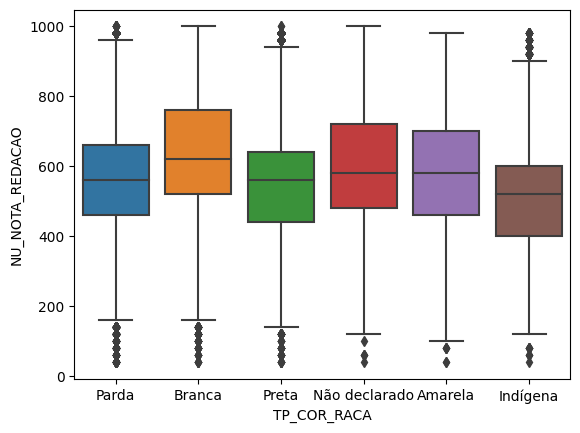

In [86]:
sns.boxplot(dados_sem_redacao_0, x = 'TP_COR_RACA', y ='NU_NOTA_REDACAO')

<font color='purple'>Resumindo os resultados:</font><br><br>

$H_0$: A nota da média redação de pessoas Brancas é maior que a de pessoas Pardas <br> <font color='green'>Aceito</font> <br><br>
$H_0$: A nota da média redação de pessoas Não-Declaradas é maior que a de pessoas Pardas <br> <font color='green'>Aceito</font> <br><br>
$H_0$: A nota da média redação de pessoas Amarela é maior que a de pessoas Pardas <br> <font color='green'>Aceito</font> <br><br>
$H_0$: A nota da média redação de pessoas Não-Declarads é maior que a de pessoas Pretas <br> <font color='green'>Aceito</font> <br><br>
$H_0$: A nota da média redação de pessoas Amarela é maior que a de pessoas Pretas <br> <font color='green'>Aceito</font> <br><br>